In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import plotly.graph_objs as go
import nbformat

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
class BankData:
    def __init__(self, path) -> None:
        self.path = path
        self.data = None

    def load_data(self):
        self.data = pd.DataFrame(loadarff(self.path)[0])
        self.data["class"] = self.data["class"].apply(lambda x: int(x))

    def remove_outliers(self):
        outliers_data = self.data.drop(columns="class").copy()
        for column in outliers_data.columns:
            mean, std = np.mean(outliers_data[column]), np.std(outliers_data[column])
            outliers_data[column] = outliers_data[column].apply(
                lambda x: x if mean - 3 * std <= x else np.nan
            )
            outliers_data[column] = outliers_data[column].apply(
                lambda x: x if x <= mean + 3 * std else np.nan
            )
        self.data[outliers_data.columns] = outliers_data

    # def remove_nans_columns(self):
    #     for column in self.data.columns:
    #         nan_ratio = (
    #             len(self.data.loc[self.data[column].isnull()][column])
    #             / self.data.shape[0]
    #         )
    #         if nan_ratio > 0.01:
    #             self.data.drop(columns=column, inplace=True)

    # def remove_nans_rows(self):
    #     self.data = self.data.dropna()
    #     self.data.reset_index(inplace=True, drop=True)

    def remove_nans_columns(self):
        for column in self.data.columns:
            nan_ratio = (
                len(self.data.loc[self.data[column].isnull()][column])
                / self.data.shape[0]
            )
            if nan_ratio > 0.1:
                self.data.drop(columns=column, inplace=True)

    def remove_nans_rows(self):
        nans_df = self.data.drop(columns="class", inplace=False)
        for column in nans_df.columns:
            mean_value = nans_df[column].mean()
            nans_df[column].fillna(mean_value, inplace=True)

        if 'class' in self.data.columns:
            nans_df['class'] = self.data['class'].values
        self.data = nans_df.copy()
        
    def standardise(self):
        scaler = StandardScaler()
        data_to_scale = self.data.copy()
        data_to_scale.drop(columns="class", inplace=True)
        scaler.fit(data_to_scale)
        scaled_data = scaler.transform(data_to_scale)
        self.data[data_to_scale.columns] = scaled_data

    def normalize(self):
        data_to_normalize = self.data.drop(columns="class").copy()
        normalizer = MinMaxScaler()
        df_normalized = pd.DataFrame(
            normalizer.fit_transform(data_to_normalize),
            columns=data_to_normalize.columns,
        )
        self.data[df_normalized.columns] = df_normalized

    def split_sample(self):
        self.train_data, self.test_data = train_test_split(self.data, test_size = 0.2, stratify= self.data['class'], random_state=42)
        self.train_data = self.train_data.reset_index(drop = True)
        self.test_data = self.test_data.reset_index(drop = True)
    def get_basic_info(self):
        self.df_b0 = self.data[self.data['class'] == 0].drop(columns = 'class').copy()
        self.df_b1 = self.data[self.data['class'] == 1].drop(columns = 'class').copy()
        self.df_b0_info = pd.DataFrame({col: [self.df_b0[col].mean(),self.df_b0[col].var(), int(self.df_b0[col].isna().sum())]  for col in self.df_b0.columns}, index=('mean', 'variance', 'nans number')).round(2)
        self.df_b1_info = pd.DataFrame({col: [self.df_b1[col].mean(),self.df_b1[col].var(), int(self.df_b1[col].isna().sum())]  for col in self.df_b1.columns}, index=('mean', 'variance', 'nans number')).round(2)
        print("Class 0")
        display(self.df_b0_info)
        print("Class 1")
        display(self.df_b1_info)


In [4]:
class Analyzer:
    def __init__(self, data: BankData) -> None:
        self.bank_data = data

    def load_and_transform(self):
        self.load_data()
        self.remove_outliers()
        self.remove_nans(axis=1)
        self.remove_nans(axis=0)
        self.standardise()
        self.normalize()
        self.split_sample()

    def load_data(self):
        self.bank_data.load_data()

    def remove_outliers(self):
        self.bank_data.remove_outliers()

    def remove_nans(self, axis=0):
        if axis == 1:
            self.bank_data.remove_nans_columns()
        elif axis == 0:
            self.bank_data.remove_nans_rows()
        else:
            raise TypeError

    def standardise(self):
        self.bank_data.standardise()

    def normalize(self):
        self.bank_data.normalize()

    def split_sample(self):
        self.bank_data.split_sample()

    def get_basic_info(self):
        self.bank_data.get_basic_info()
    def get_boxplots(self, keys):
        def generate_plot(df):
            fig, ax = plt.subplots(figsize = (15,8))
            sns.boxplot(df)
            ax.set_title(key)
            return fig
        self.fig_dict = {}
        for key in keys:  
            generate_plot(self.bank_data.data[key])

    def compute_correlation(self):
        self._correlation_matrix = self.bank_data.data.drop(columns="class").corr()

    def get_heatmap(self):
        plt.figure(figsize=(16, 12))
        sns.heatmap(
            self._correlation_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.1
        )
        plt.title("Heatmap - Correlation Matrix")
        plt.show()

    def compute_PCA(self, split_sampled = True, make_plots = True):
        pca_data = self.bank_data.data.drop(columns="class")
        n = pca_data.shape[1]
        names = [f"PC{i+1}" for i in range(n)]

        if split_sampled:
            pca_data_train = self.bank_data.train_data.drop(columns = 'class')
            pca_data_test = self.bank_data.test_data.drop(columns = 'class')
          
        def pca_fitting(df):
            pca = PCA(n_components=n)
            return pca, pca.fit_transform(df)
        res = pca_fitting(pca_data)
        self._pca_data = pd.DataFrame(res[1], columns=names)
        self._pca_data['class'] = self.bank_data.data['class']
        if split_sampled: 
            self._pca_data_train = pd.DataFrame(pca_fitting(pca_data_train)[1], columns=names)
            self._pca_data_test = pd.DataFrame(pca_fitting(pca_data_test)[1], columns=names)
            self._pca_data_train["class"] = self.bank_data.train_data['class'] 
            self._pca_data_test['class'] = self.bank_data.test_data['class']
        
        if make_plots:
            pca = res[0]
            fig1, ax1 = plt.subplots(figsize=(10, 8))
            sns.barplot(
                x=list(range(n)), y=np.cumsum(pca.explained_variance_ratio_), ax=ax1
            )
            ax1.set_xticks(ticks=range(n), labels=names)
            ax1.axhline(0.7)
            fig3 = go.Figure()
            colors = ['blue', 'orange']
            for i in range(2):
                fig3.add_trace(go.Scatter3d(x=self._pca_data[self._pca_data['class'] == i]['PC1'], y=self._pca_data[self._pca_data['class'] == i]['PC2'], z=self._pca_data[self._pca_data['class'] == i]['PC3'], name = f'Class {i}', marker = dict(color = colors[i])))
            fig3.update_layout(scene=dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
            fig3.show()
            fig2, ax3 = plt.subplots(figsize=(10, 8))
            sns.scatterplot(x="PC1", y="PC2", hue="class", data=self._pca_data, ax=ax3)
            ax3.set_xlabel("PC1")
            ax3.set_ylabel("PC2")
            ax3.set_title("PCA: PC1 vs PC2 with Categories")
            ax3.legend()
            self._pca_fig1 = fig1
            self._pca_fig2 = fig2
            self._pca_fig3 = fig3

    def compute_tSNE(self):
        self._tsne_2d = pd.DataFrame(columns = ['x', 'y', 'class'])
        self._tsne_3d = pd.DataFrame(columns = ['x', 'y', 'z', 'class'])
        tsne_data = self.bank_data.data.drop(columns="class")
        tsne_2d = TSNE(n_components = 2, learning_rate=50)
        tsne_2d_features = tsne_2d.fit_transform(tsne_data)
        self._tsne_2d['x'] = tsne_2d_features[:, 0]
        self._tsne_2d['y'] = tsne_2d_features[:, 1]
        self._tsne_2d['class'] = self.bank_data.data['class']
        fig1, ax1 = plt.subplots(figsize = (10,8))
        sns.scatterplot(x = 'x', y = 'y', hue = 'class', ax = ax1, data = self._tsne_2d)
        ax1.set_title("tSNE: 2D")
        tsne_3d = TSNE(n_components = 3, learning_rate=50)
        tsne_3d_features = tsne_3d.fit_transform(tsne_data)
        self._tsne_3d['x'] = tsne_3d_features[:, 0]
        self._tsne_3d['y'] = tsne_3d_features[:, 1]
        self._tsne_3d['z'] = tsne_3d_features[:, 2]
        self._tsne_3d['class'] = self.bank_data.train_data['class']
        self._tsne_3d['class'] = self.bank_data.data['class']
        fig2 = go.Figure()
        colors = ['blue', 'orange']
        for i in range(2):
            fig2.add_trace(go.Scatter3d(x=self._tsne_3d[self._tsne_3d['class'] == i]['x'], y=self._tsne_3d[self._tsne_3d['class'] == i]['y'], z=self._tsne_3d[self._tsne_3d['class'] == i]['z'], name = f'Class {i}', marker = dict(color = colors[i])))
        fig2.update_layout(scene=dict(
                xaxis_title='x',
                yaxis_title='y',
                zaxis_title='z'),
                width=700,
                margin=dict(r=20, l=10, b=10, t=10))
        fig2.show()
        self.tsne_fig1 = fig1
        self.tsne_fig2 = fig2
    def svm(self, on_pca = False):
        svm_model = SVC(kernel='linear')

        data_to_train = self._pca_data_train[[f"PC{i+1}" for i in range(7)] + ['class']].copy() if on_pca else self.bank_data.train_data.copy()
        data_to_test = self._pca_data_test[[f"PC{i+1}" for i in range(7)] + ['class']].copy() if on_pca else self.bank_data.test_data.copy()
        svm_model.fit(data_to_train[data_to_train.columns[:-1]], data_to_train['class'])
        svm_predictions = svm_model.predict(data_to_test[data_to_test.columns[:-1]])
        
        self.svm_cm = confusion_matrix(data_to_test['class'], svm_predictions)
        tn, fp, fn, tp  = self.svm_cm.ravel()
        recall = recall_score(data_to_test['class'], svm_predictions)
        precision = precision_score(data_to_test['class'], svm_predictions, average='weighted')
        accuracy = accuracy_score(data_to_test['class'], svm_predictions)
        f1 = f1_score(data_to_test['class'], svm_predictions, average='weighted')
        self.svm_results = {'sensitivity':recall, 'specifity':tn/(fp+tn), 'precision': precision, 'acc': accuracy, 'f1':f1}
        self.svm_cm = pd.DataFrame(self.svm_cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    def xgboost(self, on_pca = False):
        xgb_model = XGBClassifier()
        
        data_to_train = self._pca_data_train[[f"PC{i+1}" for i in range(7)] + ['class']].copy() if on_pca else self.bank_data.train_data.copy()
        data_to_test = self._pca_data_test[[f"PC{i+1}" for i in range(7)] + ['class']].copy() if on_pca else self.bank_data.test_data.copy()
        xgb_model.fit(data_to_train[data_to_train.columns[:-1]], data_to_train['class'])
        xgb_predictions = xgb_model.predict(data_to_test[data_to_test.columns[:-1]])

        self.xgb_cm = confusion_matrix(data_to_test['class'], xgb_predictions)
        tn, fp, fn, tp  = self.xgb_cm.ravel()
        recall = recall_score(data_to_test['class'], xgb_predictions)
        precision = precision_score(data_to_test['class'], xgb_predictions, average='weighted')
        accuracy = accuracy_score(data_to_test['class'], xgb_predictions)
        f1 = f1_score(data_to_test['class'], xgb_predictions, average='weighted')
        self.xgb_results = {'sensitivity':recall, 'specifity':tn/(fp+tn), 'precision': precision, 'acc': accuracy, 'f1':f1}
        self.xgb_cm = pd.DataFrame(self.xgb_cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])


In [ ]:
# weighted precision, pca komponenty, alpha na 3D, pipeline na sklearn

# Loading data, correlation, transforming data

In [5]:
year = 1
bankdata = BankData(fr"C:\Users\krzys\Sztuczna Inteligencja\Semestr 1\ML\data\polish+companies+bankruptcy+data/{year}year.arff")
analyzer = Analyzer(bankdata)

In [6]:
analyzer.load_data()
analyzer.get_basic_info()

Class 0


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
mean,0.04,0.49,0.19,2.61,-2.482100e+02,0.12,0.33,2.62,5.70,1.95,0.36,0.82,2.18,0.33,1.657420e+03,0.89,3.75,0.33,0.49,1.206820e+03,10.65,0.3,0.45,0.57,1.38,0.85,1.347030e+03,2.78,4.20,24.44,0.5,187.63,7.10,3.58,0.32,6.04,178.43,2.04,0.28,0.80,0.62,0.27,4.767900e+03,3.561120e+03,-31.85,1.84,88.31,0.15,-1.42,2.02,0.40,0.53,102.58,103.51,9.175590e+03,-1.640700e+02,0.25,1.650700e+02,0.28,4.456500e+02,15.78,4.929950e+03,8.11,216.07
variance,21.12,0.96,0.18,170.84,1.425799e+09,14.62,72.00,352.48,10819.55,1161.76,77.58,29.22,26526.52,72.00,7.281015e+09,32.34,384.48,72.00,976.53,9.026568e+09,179568.37,72.3,919.71,189.13,841.85,62.81,1.289401e+09,778.76,0.46,3471226.83,976.6,5998304.12,249.33,223.05,59.52,10819.72,41802191.35,1161.70,761.85,159.18,198.79,762.24,1.368514e+11,7.561150e+10,9908675.07,166.24,1332636.03,63.18,12068.55,15.52,0.17,45.07,8063501.19,8146040.48,5.434075e+09,1.818131e+08,4.85,1.818128e+08,41.71,7.090604e+08,71141.75,1.004583e+11,359.48,27466250.36
nans number,3.00,3.00,3.00,30.00,8.000000e+00,3.00,3.00,25.00,1.00,3.00,3.00,30.00,0.00,3.00,2.000000e+00,25.00,25.00,3.00,0.00,0.000000e+00,1513.00,3.0,0.00,124.00,3.00,25.00,1.910000e+02,28.00,3.00,0.00,0.0,37.00,30.00,25.00,3.00,3.00,2635.00,3.00,0.00,30.00,84.00,0.00,0.000000e+00,0.000000e+00,120.00,30.00,29.00,3.00,0.00,25.00,3.00,29.00,28.00,28.00,0.000000e+00,0.000000e+00,1.00,0.000000e+00,1.00,1.210000e+02,22.00,0.000000e+00,30.00,28.00


Class 1


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
mean,-0.21,2.30,-1.59,3.16,-635.60,-1.52,-0.19,2.61,1.96,-1.33,0.06,0.34,-0.19,-0.19,5.423390e+03,0.49,3.73,-0.19,-0.22,48.06,1.13,0.06,-0.22,-0.18,-1.52,0.43,233.42,0.83,4.05,1.75,-0.20,1.454600e+03,8.33,5.92,0.06,2.40,49.96,-1.24,0.02,1.47,0.19,0.02,116.08,68.02,12.16,2.22,48.01,0.03,-0.01,2.59,2.17,2.03,0.77,1.21,8.806400e+02,0.04,-1.11,1.02,0.35,103.40,12.34,606.27,8.62,22.31
variance,14.05,717.24,716.28,298.49,98214536.07,584.17,14.07,289.44,9.99,717.31,0.04,4.24,8.95,14.07,1.101242e+09,5.56,290.71,14.07,8.95,2344.00,0.12,0.03,8.93,14.09,780.12,4.49,5001697.19,85.98,0.51,425.40,8.75,4.576566e+08,1345.25,1356.54,0.04,10.44,139695.52,717.60,0.13,144.91,9.42,0.18,29079.92,21702.86,56660.58,159.43,2459.73,0.03,0.18,271.49,717.64,759.44,74.60,46.68,6.671050e+08,0.03,367.78,1.06,2.08,1432263.48,550.33,56675534.77,1406.72,6648.31
nans number,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,109.00,0.00,0.00,0.00,0.00,0.00,120.00,6.00,0.00,0.00,0.00,1.000000e+00,0.00,0.00,0.00,0.00,105.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,6.00,0.000000e+00,0.00,0.00,0.00,0.00,14.00,0.00,0.00,0.00,6.00


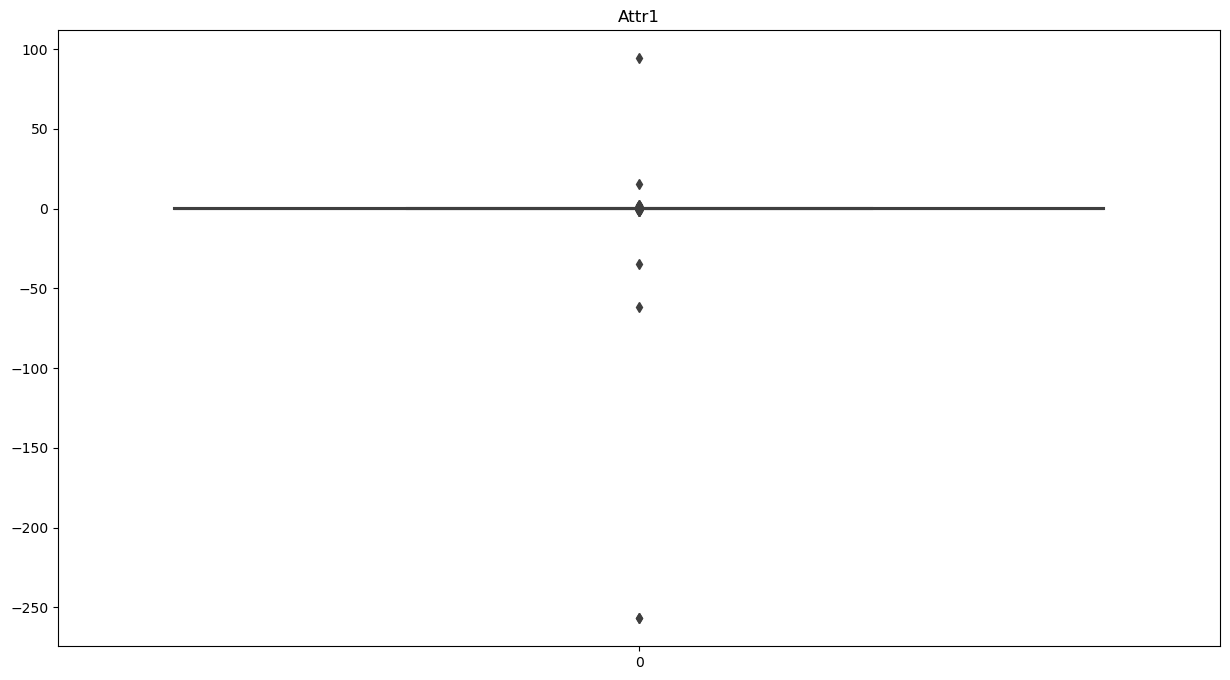

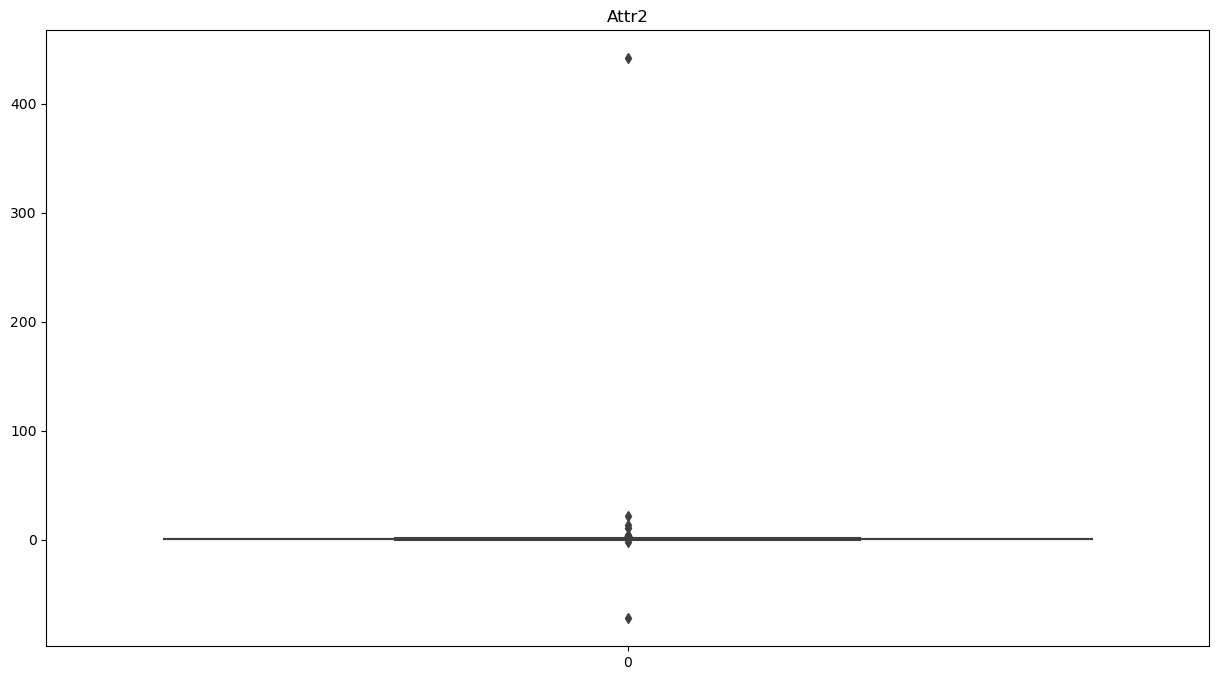

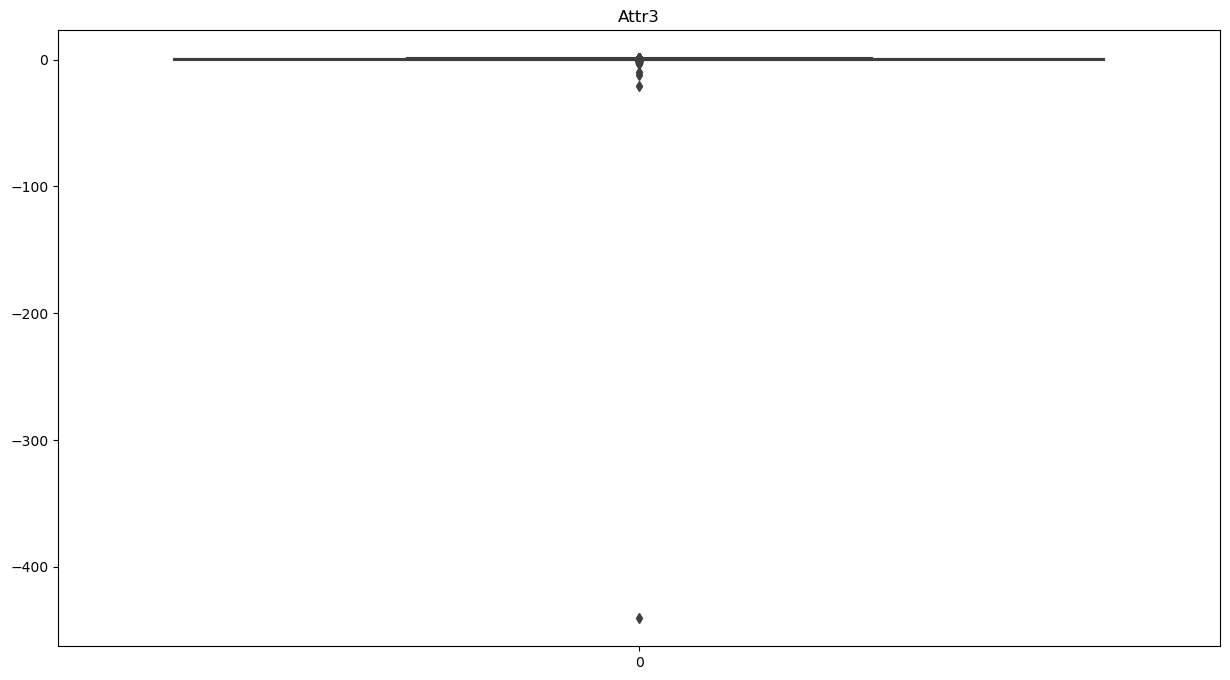

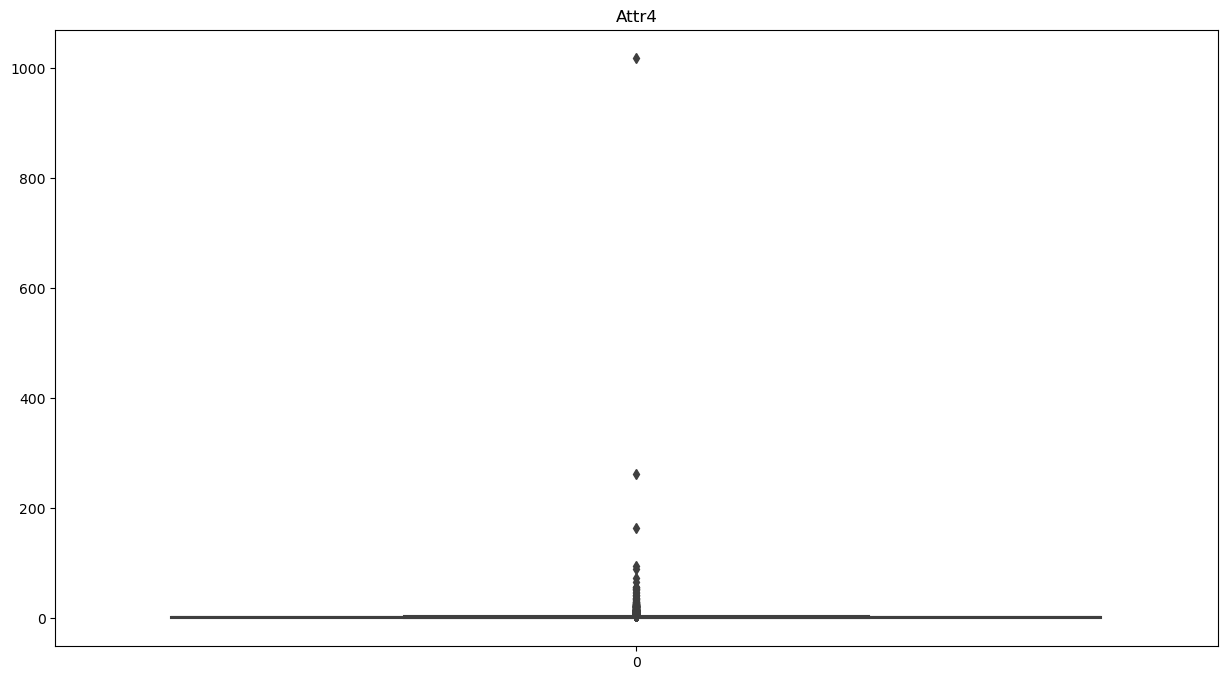

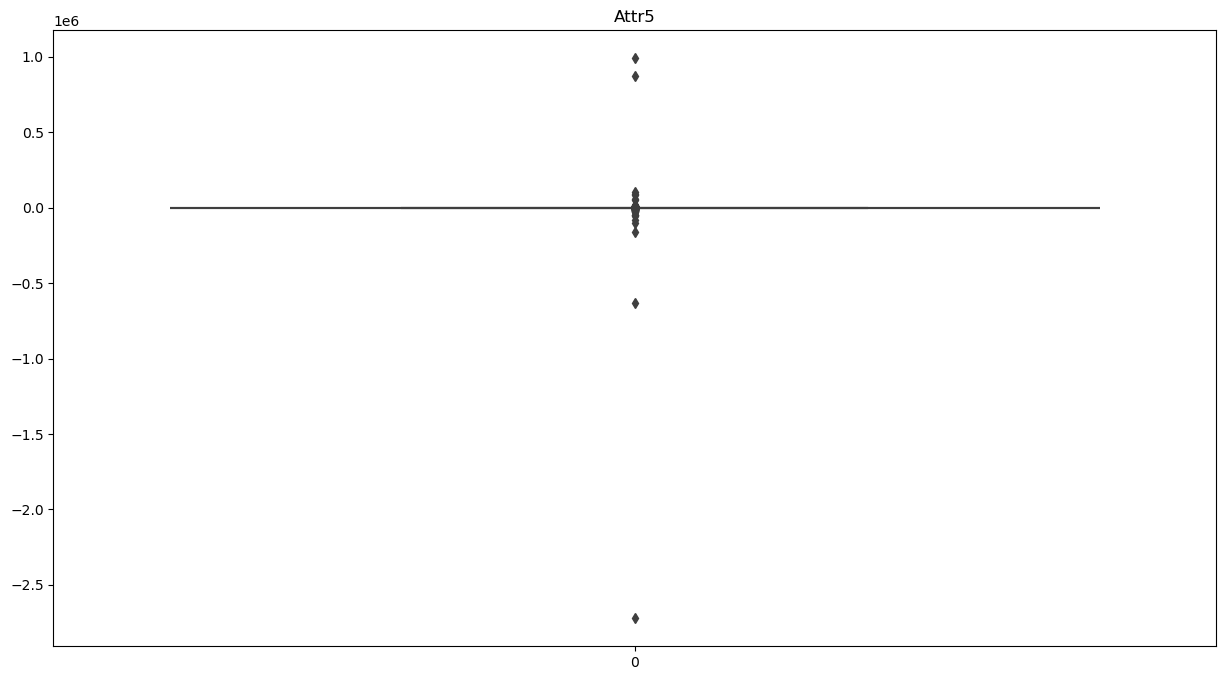

In [7]:
analyzer.get_boxplots([f'Attr{i}' for i in range(1,6)])

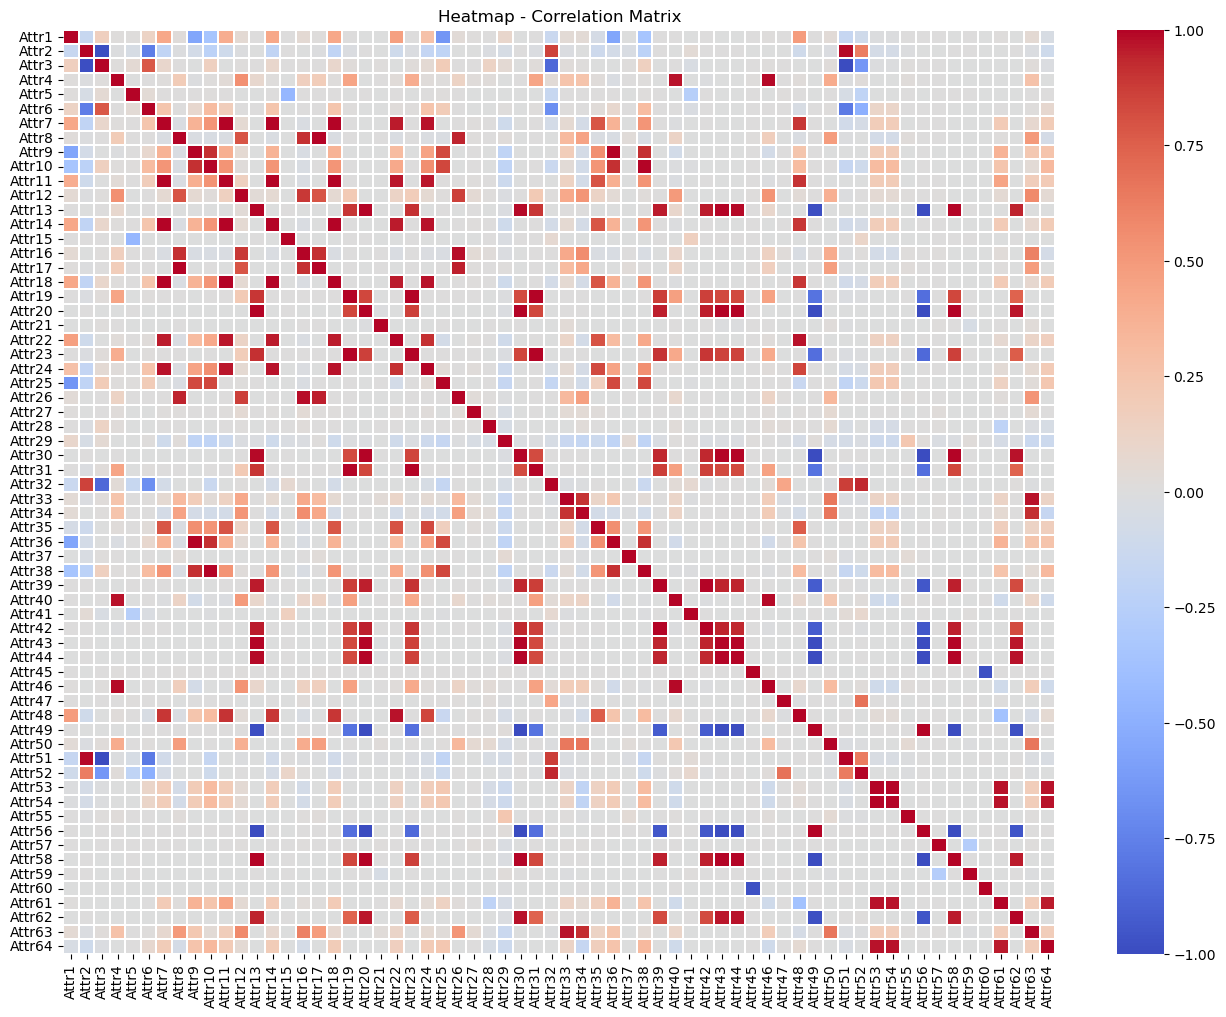

In [8]:
analyzer.compute_correlation()
analyzer.get_heatmap()

In [9]:
analyzer.load_and_transform()

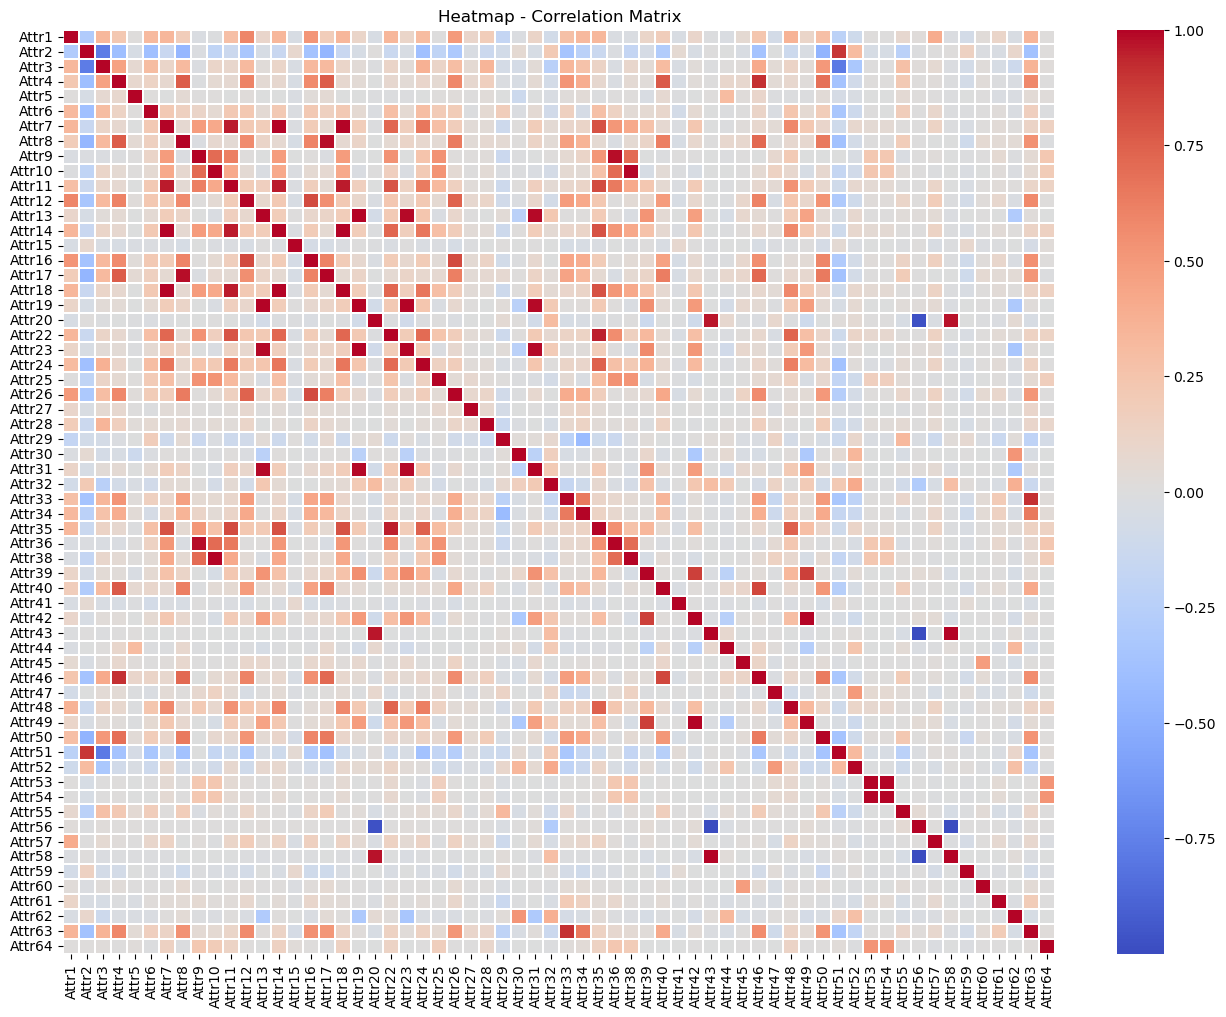

In [10]:
analyzer.compute_correlation()
analyzer.get_heatmap()

# PCA

c:\Users\krzys\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


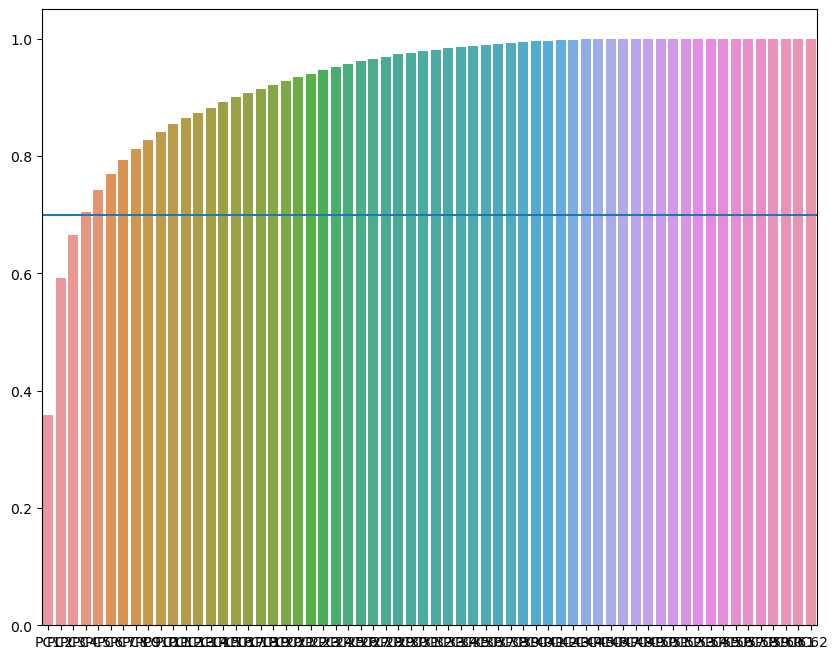

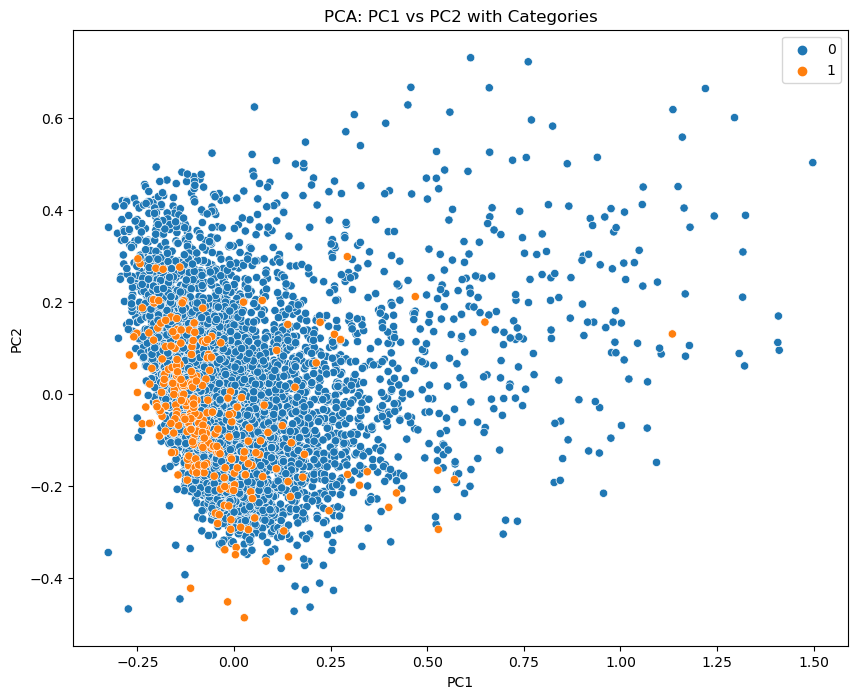

In [11]:
analyzer.compute_PCA()

# tSNE

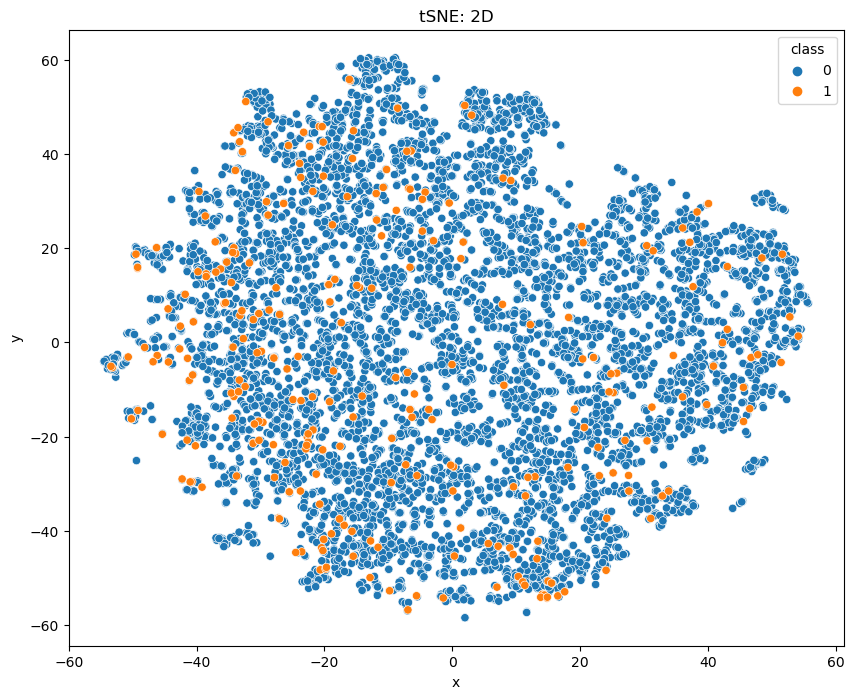

In [12]:
analyzer.compute_tSNE()

# SVM

In [13]:
analyzer.svm()

c:\Users\krzys\anaconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [14]:
analyzer.svm_cm

,Predicted Negative,Predicted Positive
Actual Negative,1352,0
Actual Positive,54,0


In [15]:
analyzer.svm_results

{'sensitivity': 0.0,
 'specifity': 1.0,
 'precision': 0.9246614286668191,
 'acc': 0.9615931721194879,
 'f1': 0.9427657496051832}

# XGBoost

In [16]:
analyzer.xgboost()

In [17]:
analyzer.xgb_cm

,Predicted Negative,Predicted Positive
Actual Negative,1349,3
Actual Positive,21,33


In [18]:
analyzer.xgb_results

{'sensitivity': 0.6111111111111112,
 'specifity': 0.9977810650887574,
 'precision': 0.9820596816563011,
 'acc': 0.9829302987197724,
 'f1': 0.9812797677216255}

# SVM on PCA

In [19]:
analyzer.svm(on_pca=True)

c:\Users\krzys\anaconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [20]:
analyzer.svm_cm

,Predicted Negative,Predicted Positive
Actual Negative,1352,0
Actual Positive,54,0


In [21]:
analyzer.svm_results

{'sensitivity': 0.0,
 'specifity': 1.0,
 'precision': 0.9246614286668191,
 'acc': 0.9615931721194879,
 'f1': 0.9427657496051832}

# XGBoost on PCA

In [22]:
analyzer.xgboost(on_pca= True)

In [23]:
analyzer.xgb_cm

,Predicted Negative,Predicted Positive
Actual Negative,1347,5
Actual Positive,54,0


In [24]:
analyzer.xgb_results

{'sensitivity': 0.0,
 'specifity': 0.996301775147929,
 'precision': 0.9245296237294435,
 'acc': 0.9580369843527738,
 'f1': 0.9409851092226299}